<a href="https://colab.research.google.com/github/farshadabdulazeez/Age_and_Gender_Prediction_using_ResNet50/blob/main/Age_and_Gender_Prediction_using_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required libraries**


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.resnet50 import ResNet50

**Download and extract the UTKFace dataset**


In [2]:
# Ensure that the Kaggle API is configured with 'kaggle.json' in the correct location.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 96% 319M/331M [00:01<00:00, 282MB/s]
100% 331M/331M [00:01<00:00, 280MB/s]


In [3]:
# Unzip the dataset
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip", 'r')
zip.extractall("/content")
zip.close()

**Prepare data**


In [4]:
# Define the path to the extracted dataset folder
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [5]:
# Extract age, gender, and image path information from file names
age = []
gender = []
img_path = []

for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))  # Extract age
    gender.append(int(file.split('_')[1]))  # Extract gender
    img_path.append(file)  # Store image path

In [6]:
# Create a DataFrame with the extracted data
df = pd.DataFrame({'age': age, 'gender': gender, 'img': img_path})

In [7]:
# Split the data into training and testing sets
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [8]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (18966, 3)
Testing data shape: (4742, 3)


**Define a custom data generator**


In [9]:
def custom_generator(df, folder_path, target_size, batch_size):
    """
    Custom generator to yield batches of images and corresponding labels.
    """
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i + batch_size]
            images = []  # List to hold images
            age_labels = []  # List to hold age labels
            gender_labels = []  # List to hold gender labels

            for _, row in batch_df.iterrows():
                img_path = os.path.join(folder_path, row['img'])
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img) / 255.0  # Normalize pixel values
                images.append(img_array)
                age_labels.append(row['age'])
                gender_labels.append(row['gender'])

            # Convert lists to numpy arrays
            images = np.array(images)
            age_labels = np.array(age_labels)
            gender_labels = np.array(gender_labels)

            # Yield a tuple: (inputs, targets)
            yield images, {'age': age_labels, 'gender': gender_labels}

In [10]:
# Define batch size
batch_size = 32

In [11]:
# Create training and testing generators
train_generator = custom_generator(train_df, folder_path, target_size=(200, 200), batch_size=batch_size)
test_generator = custom_generator(test_df, folder_path, target_size=(200, 200), batch_size=batch_size)

In [12]:
# Load the ResNet50 model without the top layer
resnet = ResNet50(include_top=False, input_shape=(200, 200, 3))
resnet.trainable = False  # Freeze the ResNet layers

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Add custom layers for multi-output prediction
flatten = Flatten()(resnet.output)

In [14]:
# Branch for age prediction
age_branch = Dense(512, activation='relu')(flatten)
age_output = Dense(1, activation='linear', name='age')(age_branch)

In [15]:
# Branch for gender prediction
gender_branch = Dense(512, activation='relu')(flatten)
gender_output = Dense(1, activation='sigmoid', name='gender')(gender_branch)

**Create the functional model**


In [16]:
model = Model(inputs=resnet.input, outputs=[age_output, gender_output])

**Compile the model with appropriate losses and metrics**


In [17]:
model.compile(
    optimizer='adam',
    loss={'age': 'mae', 'gender': 'binary_crossentropy'},
    metrics={'age': 'mae', 'gender': 'accuracy'},
    loss_weights={'age': 1.0, 'gender': 99.0}
)

**Train the model**


In [18]:
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(test_df) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_generator,
    validation_steps=validation_steps
)

Epoch 1/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 87s 124ms/step - age_loss: 18.3228 - age_mae: 18.3228 - gender_accuracy: 0.5120 - gender_loss: 177.7976 - loss: 196.1204 - val_age_loss: 15.0053 - val_age_mae: 15.0053 - val_gender_accuracy: 0.5205 - val_gender_loss: 68.5427 - val_loss: 83.5480
Epoch 2/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - age_loss: 14.4794 - age_mae: 14.4974 - gender_accuracy: 0.5229 - gender_loss: 68.5238 - loss: 83.0246 - val_age_loss: 14.0985 - val_age_mae: 14.1053 - val_gender_accuracy: 0.5210 - val_gender_loss: 68.5515 - val_loss: 82.6395
Epoch 3/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 68s 115ms/step - age_loss: 13.7849 - age_mae: 13.8016 - gender_accuracy: 0.5226 - gender_loss: 68.5193 - loss: 82.3258 - val_age_loss: 14.0394 - val_age_mae: 14.0380 - val_gender_accuracy: 0.5200 - val_gender_loss: 68.5641 - val_loss: 82.5837
Epoch 4/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - age_loss: 13.1084 - age_mae: 13.1174 - gender_accuracy: 0.5228 - gender_loss: 68.5171 - loss

**Analyze predictions**

In [19]:
test_images, test_labels = next(test_generator)  # Get a batch of test data
predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [20]:
# Extract age and gender predictions
predicted_ages = predictions[0]
predicted_genders = predictions[1]

In [21]:
print("Predicted ages:", predicted_ages[:5])
print("Predicted genders:", (predicted_genders[:5] > 0.5).astype(int))

Predicted ages: [[31.982605]
 [33.801064]
 [42.29461 ]
 [31.629717]
 [22.606874]]
Predicted genders: [[0]
 [0]
 [0]
 [0]
 [0]]


Structure of labels: {'age': array([37, 22, 53, 43,  3, 27, 22,  8, 32, 10, 30, 26, 66, 55,  6, 28,  1,
       58, 47,  8,  1, 65, 21, 28, 38,  4, 88, 49, 76,  3, 49, 24]), 'gender': array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0])}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


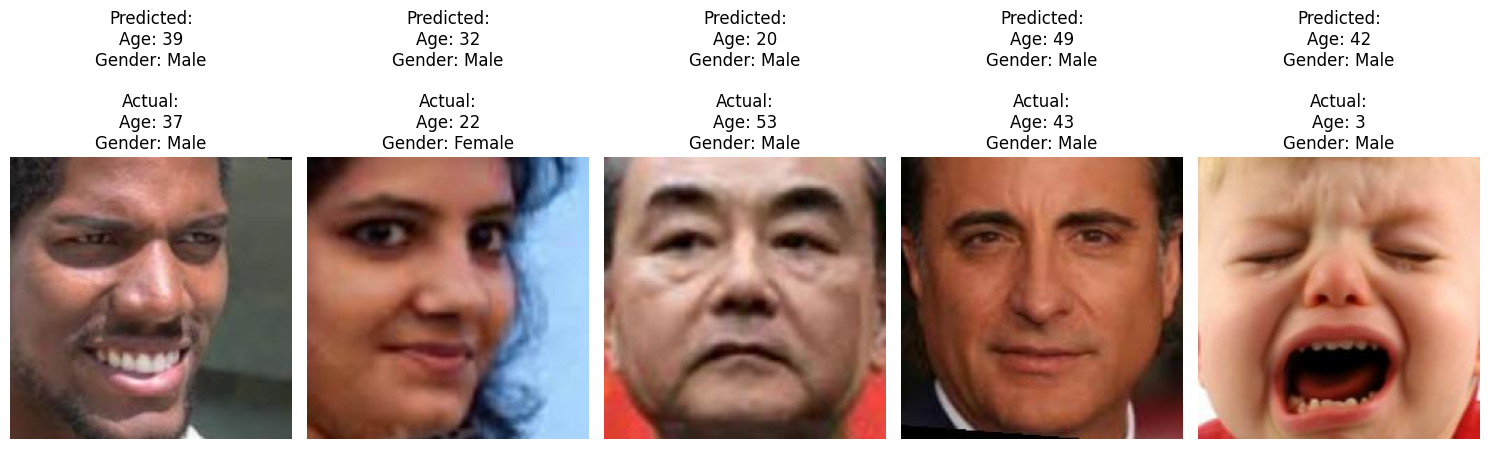

In [24]:
# Get a batch of test data
batch = next(test_generator)
images, labels = batch[0], batch[1]  # images and true labels (age and gender)

# Debug: Check the structure of labels
print("Structure of labels:", labels)

# Extract true labels from the correct structure
# If labels is a dictionary (it might be), access the keys for 'age' and 'gender'
if isinstance(labels, dict):
    true_ages = labels['age']
    true_genders = labels['gender']
else:
    # If labels is a list, access by index
    true_ages = labels[0]
    true_genders = labels[1]

# Predict on the batch
predictions = model.predict(images)
predicted_ages = predictions[0]
predicted_genders = (predictions[1] > 0.5).astype(int)

# Display the first 5 images with their true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    # Show predicted and true values
    pred_age = int(predicted_ages[i][0])
    true_age = int(true_ages[i])
    pred_gender = "Female" if predicted_genders[i][0] == 1 else "Male"
    true_gender = "Female" if true_genders[i] == 1 else "Male"

    plt.title(f"Predicted:\nAge: {pred_age}\nGender: {pred_gender}\n\n"
              f"Actual:\nAge: {true_age}\nGender: {true_gender}")

plt.tight_layout()
plt.show()
